In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import scipy.special as ss
import sys

In [74]:
def gen_data(n_pix, n_pulse, t_inter_p, lifetimes, spec_ind, exc_probs, tau_irf, sig_irf, bg):
    '''
    genData() generates a set of arrival times from input lifetimes 
    and excitation probability.
    
    Args:
        npix (int): Number of pixels.
        npulse (int): Number of pulses per pixel.
        t_inter_p (float): Interpulse time (ns).
        lifetimes (array-like): Array of species lifetimes (ns).
        spec_ind (array-like): Index to assign spectrum from the list to species.
        exc_probs (array-like): Species excitation probabilities.
        tau_irf (float): Mean of the instrument response function (IRF) (ns).
        sig_irf (float): Standard deviation of the IRF (ns).
        bg (float): Background parameter for Poisson noise.    
    
    Returns:
        tuple: A tuple containing the following:
            dt (list): Simulated arrival times per pixel.
            lambda_ (ndarray): Number of simulated photons per spectral band per pixel.
            spec_inten (ndarray): Number of simulated photons per spectral band per pixel per species.
    '''
    alphas = np.array([1.4, 55, 420, 150, 200])
    betas = np.array([30, 10, 1.6, 3.25, 2.9])
    spec_bands = np.linspace(375, 760, 32)
    n_spec = lifetimes.size

    n_channel = spec_bands.size
    lambda_ = np.zeros((n_pix, n_channel))
    nn = spec_ind.size
    spec_inten = np.zeros((n_pix, nn, n_channel))
    dt = []

    total_exc_prob = np.sum(exc_probs, axis=0)
    exc_probs = (exc_probs / total_exc_prob).T
    for pp in range(n_pix):

       
        pulse_excitation = 1 - np.exp(-2 * sig_irf * total_exc_prob[pp])
        pulse_excitation = pulse_excitation > np.random.rand(n_pulse)

        exc_pulse_indices = np.where(pulse_excitation)[0]
        exc_species_indices = np.random.choice(n_spec, size=len(exc_pulse_indices), p=exc_probs[pp])
        exc_species_lifetimes = lifetimes[exc_species_indices]

        exc_times = np.random.normal(tau_irf, sig_irf, len(exc_pulse_indices)) + np.random.exponential(exc_species_lifetimes)
        arrival_times = exc_times - t_inter_p * np.floor(exc_times / t_inter_p)

        tmp_lamds = np.random.gamma(alphas[exc_species_indices+1], betas[exc_species_indices+1])
        tmp_id = np.digitize(tmp_lamds, spec_bands) - 1
        tmp_id = np.clip(tmp_id, 0, 31)        

        lambda_[pp] += np.bincount(tmp_id, minlength=32)
        
        # unique_species_indices, unique_counts = np.unique(exc_species_indices, return_counts=True)
        # spec_inten[pp, unique_species_indices, tmp_id] += unique_counts
        dt.append(arrival_times)
        # spec_inten[pp] /= np.sum(spec_inten[pp], axis=1, keepdims=True)
    
    return dt, lambda_, spec_inten

In [75]:
NPix = 5
NPulse = 10**5
#print(NPulse)
TInterP = 12.8
#print(TInterP)
Lifetimes = np.array([0.5, 2, 7])
SpecInd = np.array([1, 2, 3])
#print(Lifetimes)
ExcProbs = np.array([[0.008, 0.008, 0.008], [0.008, 0, 0.008], [0, 0.008, 0.008], [0.008, 0.008, 0], [0, 0, 0.008]]).T
#print(ExcProbs)
TauIRF = 8
#print(TauIRF)
SigIRF = 0.5
#print(SigIRF)
bg = 10

Dt,Lambda,_ = gen_data(NPix, NPulse, TInterP, Lifetimes, SpecInd, ExcProbs, TauIRF, SigIRF, bg)


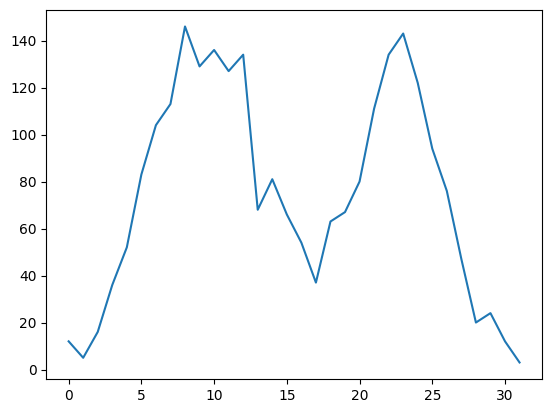

In [76]:
plt.plot(Lambda[0,:])

In [77]:
def sample_photon_probability(lambd, phi_old, pi, n_pix, accept_phi):
    
    """
    Sample the probability of a photon from the species to be detected in the lth spectral band.

    Args:
        lambd (numpy.ndarray): representing the number of photons per spectral band.
        phi_old (numpy.ndarray): representing current photon probabilities.
        pi (numpy.ndarray): Array of shape (NSpecies, NPix) representing photon ratios per pixel per species.
        n_pix (int): Total number of pixels.
        accept_phi (float): Accumulated acceptance rate.

    Returns:
        tuple: Tuple containing the updated phi_old array and the updated accept_phi value.
    """

    n_species, n_channel = phi_old.shape
    alpha = np.ones(n_channel) / n_channel
    alpha_prop = 1000

    i_0 = np.sum(lambd, axis=1)
    phi_new = np.copy(phi_old)
    m = np.random.choice(n_species)

    phi_new[m, :] = np.random.gamma(alpha_prop, phi_old[m, :] / alpha_prop)
    phi_new[m] /= np.sum(phi_new[m])
    a_top = 0
    a_bottom = 0
    for ii in range(np.size(i_0)):
        for ll in range(n_channel):
            tmp_top = np.sum(pi[:, ii] * phi_new[:,ll])
            if tmp_top > 0.001:
                a_top += sc.poisson.logpmf(lambd[ii, ll], tmp_top)
            tmp_b = np.sum(pi[:, ii] * phi_old[:, ll])
            if tmp_b > 0.001:
                a_bottom += sc.poisson.logpmf(lambd[ii, ll], tmp_b)

    # Calculating priors and proposal distributions
    a_prop = 0
    a_prior = 0
    for mm in range(phi_old.shape[0]):
        a_prop += np.sum(sc.dirichlet.logpdf(phi_old[mm,:], phi_new[mm,:])) - np.sum(sc.dirichlet.logpdf(phi_new[mm,:], phi_old[mm,:]))
        a_prior += np.sum(sc.dirichlet.logpdf(phi_new[mm,:], alpha/n_channel)) - np.sum(sc.dirichlet.logpdf(phi_old[mm,:], alpha/n_channel))
    a = (a_top - a_bottom) + a_prop + a_prior
    tmp_accept = 0
    if a > np.log(np.random.rand()):
        phi_old = phi_new
        tmp_accept = tmp_accept + 1

    accept_phi += tmp_accept 
    return phi_old, accept_phi

In [78]:
def runSFLIM_sampler(Dt,Lambda,TInterP,TauIRF,SigIRF,NIter,M):
    #runFLIM_sampler() implements the Gibbs sampling procedure as
    #described in the manuscript
    #
    # Dt: set of arrival times
    # Lambda: number of photons within as set of 32 spectral bands
    # NInterP: interpulse time (ns)  
    # TauIRF: mean of the IRF (ns)
    # SigIRF: sigma of the IRF (ns)
    # NIter: number of iterations (samples)
    # M: number of components 
    NSB = 32
    NPix = np.shape(Lambda)[0]
    print('NPix:',NPix)
    NMax = 3

    #allocating the chains
    Eta = np.zeros((NIter,M))
    I = np.zeros((NIter,M,NSB))
    phi = np.random.rand(NIter, M , NSB)
    for mm in range(M):
        phi[0,mm,:] /= np.sum(phi[0,mm,:])
    Pi = np.zeros((NIter,M,NPix))
    PiNorm = np.zeros((NIter,NPix)) 
    #pre-calculating (Tau-Dt-nT)
    Dt_mod = {}
    for nn in range(0, NPix):
        tmpDt_mod = TauIRF-Dt[nn]
        DtLength = np.size(tmpDt_mod)
        Dt_mod[nn] = np.zeros((DtLength,NMax))
        for ii in range(0, NMax):
            Dt_mod[nn][:,ii] = tmpDt_mod - ii*TInterP

    #initiualizing the chains
    #Eta[0,0:M] = np.random.gamma(1,5,M)
    Eta[0,0:M] = np.divide(1,np.array([0.5, 2, 5]))
    Pi[0,0:M,0] = [1/4, 1/2, 1/4]
    Pi[0,0:M,1] = [1/2, 0, 1/2]
    Pi[0,0:M,2] = [0, 1/2, 1/2]
    Pi[0,0:M,3] = [1/2, 1/2, 0]
    Pi[0,0:M,4] = [0, 0, 1]
    #    for ii in range(0, NPix):
    #        tmp = np.random.gamma(1,10,M)
    #        PiNorm[0,ii] = np.sum(tmp)
    #        Pi[0,:,ii] = np.divide(tmp,PiNorm[0,ii])
    #        print('Pi0:',Pi[0,:,ii])
    for ll in range(0, 32):
        I[0,:,ll] = np.random.gamma(50,2,M)

    #sampling the parameters
    AcceptI = 0
    AcceptPi = 0
    # print(Lambda[4,:])
    for jj in range(1, NIter):
        if np.floor(jj/200) == jj/200:
            print('iteration:',jj)
        #Eta[jj,:] = sample_Eta(Dt,Eta[jj-1,:],Pi[jj-1,:,:],TInterP,TauIRF,SigIRF)
        # print(np.sum(phi[jj-1], axis=0))
        phi[jj,:,:],  AcceptI = sample_photon_probability(Lambda, phi[jj-1,:,:], Pi[jj-1,:,:], NPix, AcceptI)
        tmpPi, tmpPiNorm, AcceptPi = Pi[jj-1,:,:], 1,0 #sample_Pi(Lambda,Dt_mod,I[jj-1,:,:], Pi[jj-1,:,:], PiNorm[jj-1,:], Eta[jj-1,:],TInterP,TauIRF,SigIRF,NPix,AcceptPi)
        Eta[jj,:] = Eta[jj-1,:]
        Pi[jj,:,:] = tmpPi
        #Pi[jj,:,:] = Pi[jj-1,:,:]
        #    PiNorm[jj,:] = tmpPiNorm

    print('I acceptance ratio:',100*AcceptI/NIter)
    print('Pi acceptance ratio:',100*AcceptPi/NIter)
    print(phi.shape)
    return phi, Pi

In [90]:
M = np.size(Lifetimes)
NIter = 15000
I, Pi = runSFLIM_sampler(Dt,Lambda,TInterP,TauIRF,SigIRF,NIter,M)

NPix: 5
iteration: 200
iteration: 400
iteration: 600
iteration: 800
iteration: 1000
iteration: 1200
iteration: 1400
iteration: 1600
iteration: 1800
iteration: 2000
iteration: 2200
iteration: 2400
iteration: 2600
iteration: 2800
iteration: 3000
iteration: 3200
iteration: 3400
iteration: 3600
iteration: 3800
iteration: 4000
iteration: 4200
iteration: 4400
iteration: 4600
iteration: 4800
iteration: 5000
iteration: 5200
iteration: 5400
iteration: 5600
iteration: 5800
iteration: 6000
iteration: 6200
iteration: 6400
iteration: 6600
iteration: 6800
iteration: 7000
iteration: 7200
iteration: 7400
iteration: 7600
iteration: 7800
iteration: 8000
iteration: 8200
iteration: 8400
iteration: 8600
iteration: 8800
iteration: 9000
iteration: 9200
iteration: 9400
iteration: 9600
iteration: 9800
iteration: 10000
iteration: 10200
iteration: 10400
iteration: 10600
iteration: 10800
iteration: 11000
iteration: 11200
iteration: 11400
iteration: 11600
iteration: 11800
iteration: 12000
iteration: 12200
iteratio

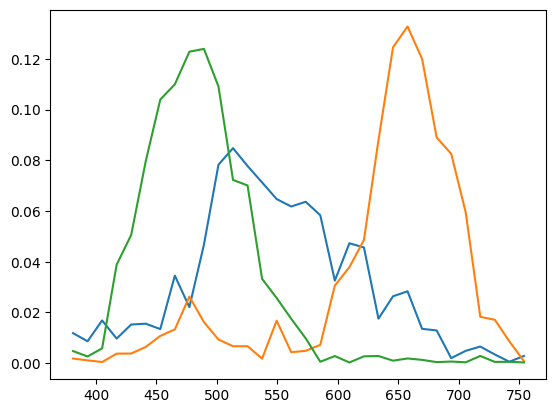

In [91]:
X = np.linspace(381,754,32)
plt.plot(X,I[-1,0,:])
plt.plot(X,I[-1,1,:])
plt.plot(X,I[-1,2,:])
plt.show()

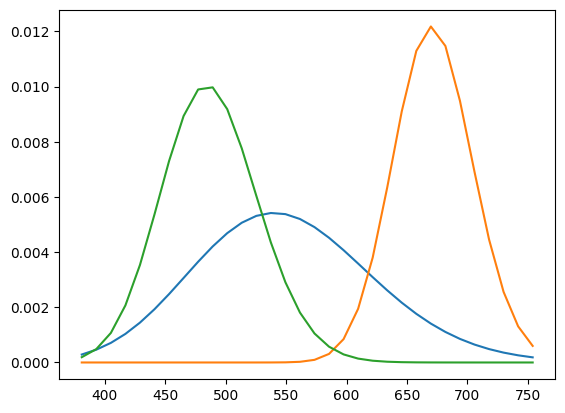

In [92]:
#alphas = np.array([1.4, 55, 420, 150, 200])
#betas = np.array([30, 10, 1.6, 3.25, 2.9])

plt.plot(X,sc.gamma.pdf(X,55,scale=10))
plt.plot(X,sc.gamma.pdf(X,420,scale=1.6))
plt.plot(X,sc.gamma.pdf(X,150,scale=3.25))